# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация


В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
#!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]
sns.set_palette("muted",2) 

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
df = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df.drop(columns=['dropoff_datetime'], inplace=True)
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

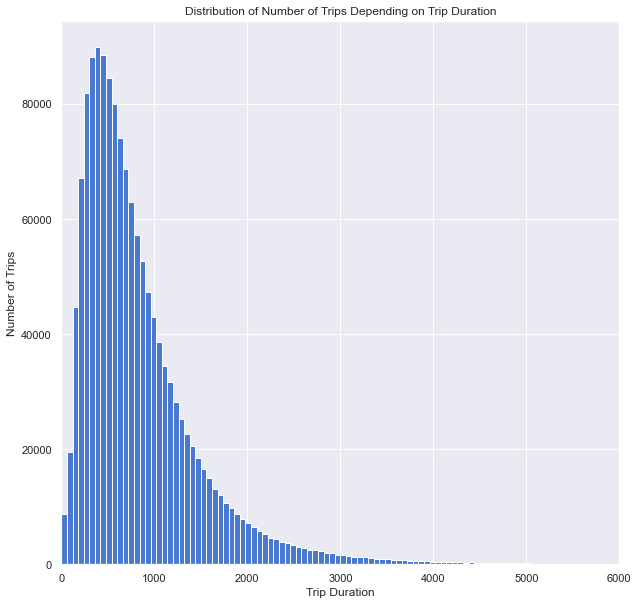

In [6]:
# Сразу при попытке построения графика без ограничения trip_duration видны выбросы, которые мешают анализу графика
plt.hist(df.trip_duration[df['trip_duration'] < 6000].values, bins=100)
plt.xlabel('Trip Duration')
plt.ylabel('Number of Trips')
plt.title('Distribution of Number of Trips Depending on Trip Duration')

plt.xlim(0, 6000)

plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Гистограмма имеет длинный хвост, идущий вправо, т.е. данные распределены со смещением вправо. Также при построении гистограммы было выявлено, что данные имеют выбросы, которые мешают адекватному оцениванию данных по графику. Основные значения целевой переменной лежат в диапазоне от 0 до 4000. Как мы убедимся далее, логарифм целевой переменный имеет нормальное распределение.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: Поскольку время поездки на такси измеряется в секундах и данные распределены от 0 до 10000+, то модель RMSE будет сильно штрафовать наши предсказания, даже если они адекватные и вполне соответствуют действительности. Модель RMSE очень чувствительна к выбросам, которые имеются в наших данных, в чем мы убедились при построении гистограммы. RMSLE сильнее штрафует за недооценку фактической переменной, чем за завышение, что может соответствовать бизнес-модели. Модель RMSLE возможно использовать в данном датасете, поскольку целевая переменная измеряется исключительно в положительных значениях. Также несомненным преимуществом является то, что функция ошибок RMSLE учитывает только относительную ошибку между прогнозируемым и фактическим значением, а масштаб ошибки не имеет значения.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 

$$
\text{RMSLE}(X, \hat{y}, {a}) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{({a}(x_i) + 1)}\big)^2} \Leftrightarrow 
\text{RMSE}(X, {y}, \hat{a}) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(\exp({y_i}) - 1 + 1)} - \log{(\exp({\hat{a}(x_i)}) - 1 + 1)}\big)^2}
\Leftrightarrow
\text{RMSE}(X, {y}, \hat{a}) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big({y_i} - \hat{a}(x_i)\big)^2}
\Leftrightarrow
\text{MSE}(X, {y}, \hat{a}) ={\frac{1}{\ell}\sum_{i=1}^{\ell} \big({y_i} - \hat{a}(x_i)\big)^2}
$$

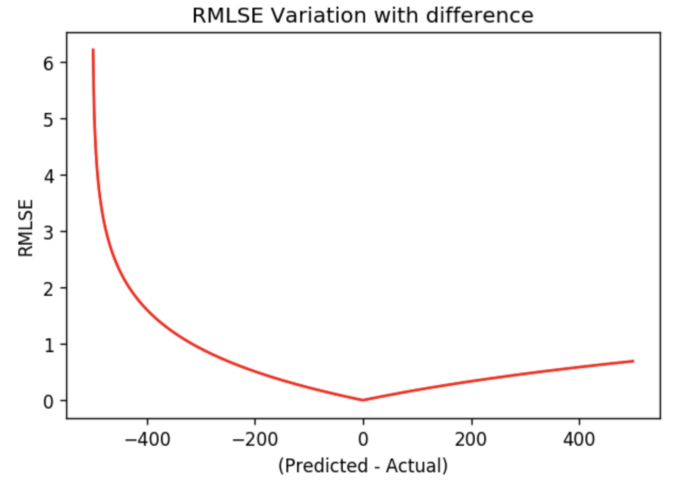

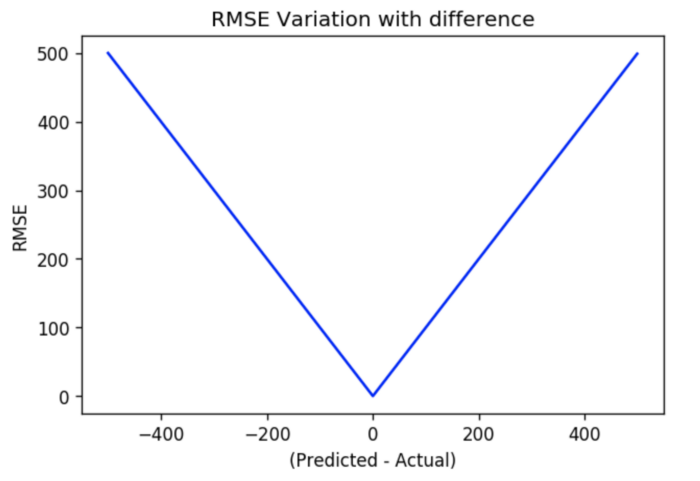
Иточник изображений: https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

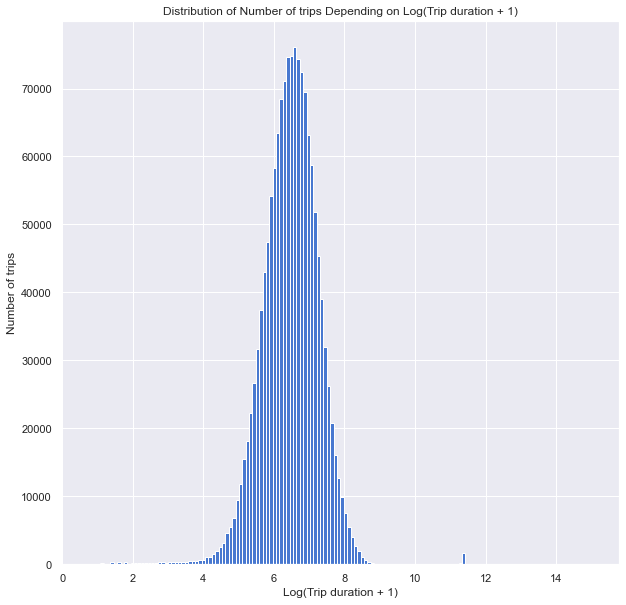

In [7]:
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
df.drop(columns = ['trip_duration'], inplace=True)

plt.hist(df.log_trip_duration.values, bins=150)
plt.xlabel('Log(Trip duration + 1)')
plt.ylabel('Number of trips')
plt.title('Distribution of Number of trips Depending on Log(Trip duration + 1)')

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
from sklearn.metrics import mean_squared_error

target = df['log_trip_duration']
target_mean_array = np.linspace(np.mean(target), np.mean(target), len(target))

MSE_conts = mean_squared_error(target, target_mean_array)

print('MSE score for tagret vs target mean - {}'.format(round(MSE_conts, 5)))

MSE score for tagret vs target mean - 0.63323


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

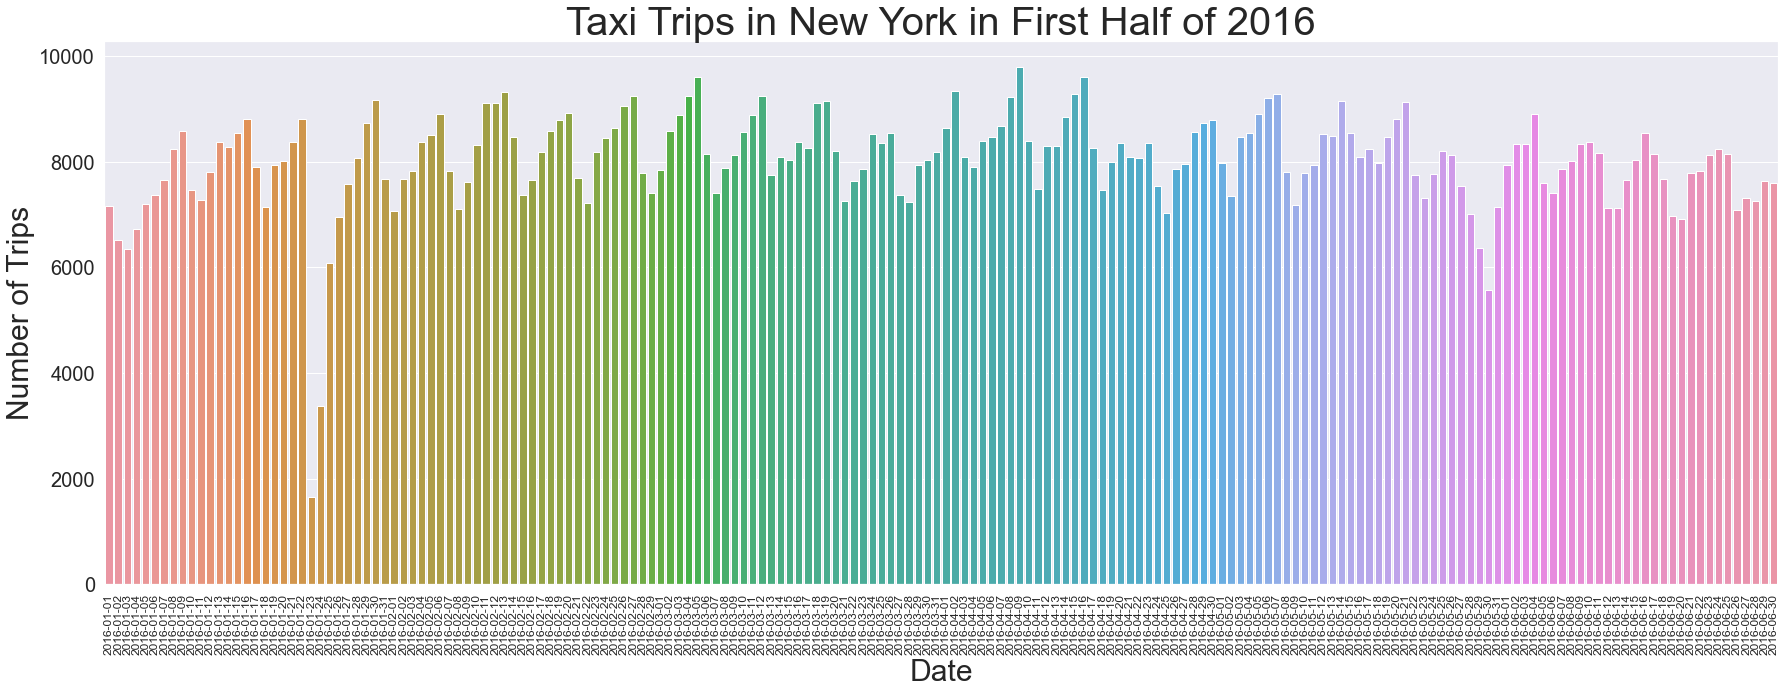

In [9]:
day_of_year = df.groupby(df['pickup_datetime'].dt.date).count()[['id']].reset_index()

plt.figure(figsize=(30, 10))
ax = plt.subplot()
sns.countplot(x = df.pickup_datetime.dt.dayofyear)
plt.xticks(rotation=90)
plt.title('Taxi Trips in New York in First Half of 2016', fontsize=40)
plt.ylabel('Number of Trips', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Date', fontsize=30)
plt.xticks(fontsize=12)
ax.set_xticklabels(day_of_year.pickup_datetime)
plt.show()

In [10]:
# Поскольку тяжело по графику определить точную дату, посмотрим даты по таблице

day_of_year.sort_values(by=['id']).head(10)

,pickup_datetime,id
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570
24,2016-01-25,6084
2,2016-01-03,6353
149,2016-05-29,6372
1,2016-01-02,6512
3,2016-01-04,6725
171,2016-06-20,6910
25,2016-01-26,6941


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: Период № 1 23-25 Января. В 2016 году в Нью-Йорке выпало аномальное количество снега, Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури.

Период № 2 29-30 Мая. Достаточно сложно дать точный ответ, что именно повлияло в этом году на уменьшение поездок в этот период, поскольку уменьшение не столь значительно как в первом периоде. Предполагаю, что уменьшение количества поездок связано с празднованием национального дня памяти в США, который отмечается ежегодно в последний понедельник мая. В добавок ко всему подготовка к празднику и сам праздник выпадают на воскресенье и понедельник, в дни, когда спрос на такси не очень большой.

Поскольку в дальнейшем нам придется вводить следующие признаки:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Добавим их сразу, так как они помогут при построении графиков

In [11]:
# jupyter ругается, заглушим ошибки
import warnings
warnings.filterwarnings('ignore')

df['day_name'] = df['pickup_datetime'].dt.day_name()
df['month_name'] = df['pickup_datetime'].dt.month_name()
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_number'] = df['pickup_datetime'].dt.dayofyear

df['winter_anomaly'] = 0
df.winter_anomaly[(df['day_number'].isin([23, 24, 25]))] = 1
df['may_anomaly'] = 0
df.may_anomaly[(df['day_number'].isin([150, 151]))] = 1

Скопируем данные чтобы не добавлять новые признаки, которые будут полезны для построения графиков. В копию датасета внесем признаки:
1. День недели (порядковый номер)
2. Месяц (порядковый номер)

In [12]:
df_copy = df.copy()
df_copy['day_num_week'] = df_copy['pickup_datetime'].dt.dayofweek
df_copy['month_num_year'] = df_copy['pickup_datetime'].dt.month

Перейдем непосредственно к графикам:

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

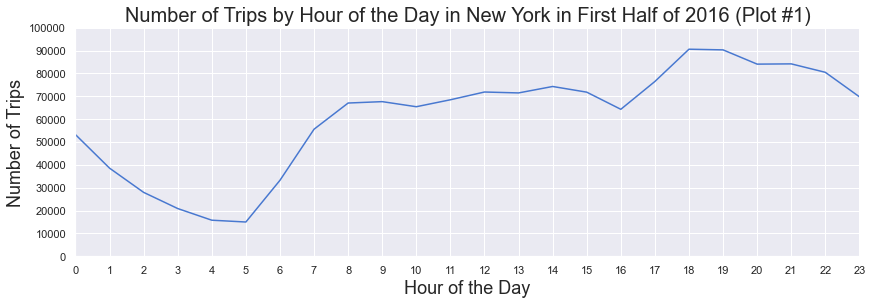

In [13]:
hour_group =  df_copy.groupby(['hour_of_day']).count()[['id']].reset_index()

h = sns.relplot(data=hour_group, x="hour_of_day", y="id", kind="line", height=4, aspect=3)

h.set(xticks=[i for i in range(24)], yticks=[i for i in range(0, 100001, 10000)], xlim=(0,23))
plt.title('Number of Trips by Hour of the Day in New York in First Half of 2016 (Plot #1)', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=18)
plt.ylabel('Number of Trips', fontsize=18)

plt.show()

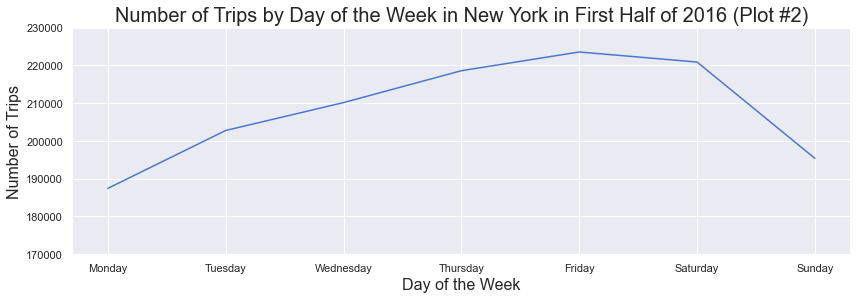

In [14]:
day_group =  df_copy.groupby(['day_num_week', 'day_name']).count()[['id']].reset_index()
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

h = sns.relplot(data=day_group, x="day_num_week", y="id", kind="line", height=4, aspect=3)
h.set(xticks=[i for i in range(7)], xticklabels = days_ordered, ylim = (170000, 230000))
plt.title('Number of Trips by Day of the Week in New York in First Half of 2016 (Plot #2)', fontsize=20)
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)

plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

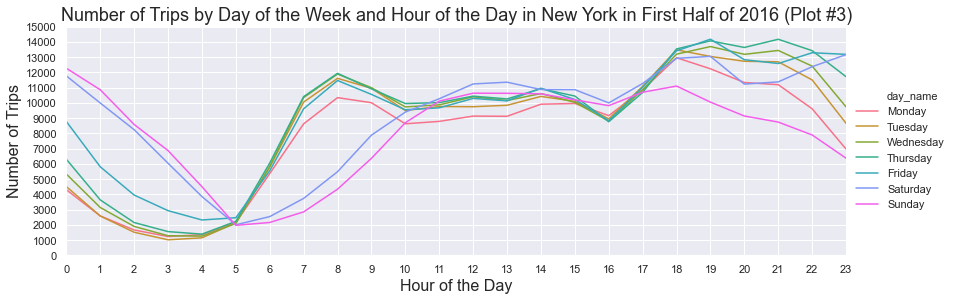

In [15]:
data_group =  df_copy.groupby(['day_num_week', 'day_name', 'hour_of_day']).count()[['id']].reset_index()

h = sns.relplot(data=data_group, x="hour_of_day", y="id", kind="line", hue="day_name", height=4, aspect=3)
h.set(xticks=[i for i in range(24)], yticks=[i for i in range(0, 15001, 1000)], xlim=(0,23))
plt.title('Number of Trips by Day of the Week and Hour of the Day in New York in First Half of 2016 (Plot #3)', fontsize=18)
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)

plt.show()

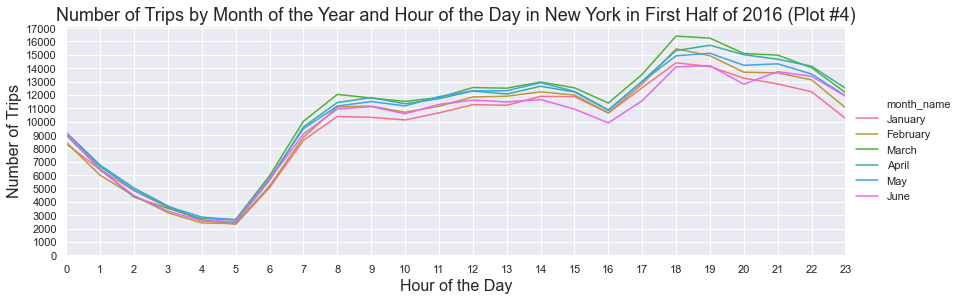

In [16]:
month_group =  df_copy.groupby(['month_num_year', 'month_name', 'hour_of_day']).count()[['id']].reset_index()

h = sns.relplot(data=month_group, x="hour_of_day", y="id", kind="line", hue="month_name", height=4, aspect=3)
h.set(xticks=[i for i in range(24)], yticks=[i for i in range(0, 17001, 1000)], xlim=(0,23))
plt.title('Number of Trips by Month of the Year and Hour of the Day in New York in First Half of 2016 (Plot #4)', 
          fontsize=18)
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)

plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Начнем интерпретировать графики по порядку. На первом графике видно, что ночью количество поездок не велико, потом идет резкий скачек к утру, в течении дня показатель держится на одном уровне, а вечером опять растет и начинает падать к ночи.

График №2 - данные показывают зависимость количества поездок от дня недели. Основываясь на данных можно сделать вывод, что количество поездок на такси возрастает в течении недели и резко сокращается в воскресенье. Можно предположить, что ближе к выходным люди предпочитают куда-то ходить и где-то проводить свой досуг, а домой возвращаться на такси. В воскресенье соответственно отдыхать дома.

График №3 в отличии от графика №2 можно интерпретировать данные как по дням недели, так и по времени суток. Данные не противоречат гипотезе, выдвинутой к графику №2. Как можно видеть, ночные поездки на такси намного популярнее в субботу и воскресенье, в дни, которые сразу идут за вечером пятницы и субботы соответственно. Форма графиков в целом соответствует форме графика №1, за исключением субботы и воскресенья, что в целом свойственно для выходных.

График №4 в целом графики соответствуют графику №1. А распределение поездок в зависимости от месяца в целом одинаковое. Небольшое расхождение в период вечера в данных предположительно может быть вызвано тем, что люди в пасмурные месяцы года более склонны к использованию такси, чем в другие времена года.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [17]:
from sklearn.model_selection import train_test_split

train_df_0, test_df_0 = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

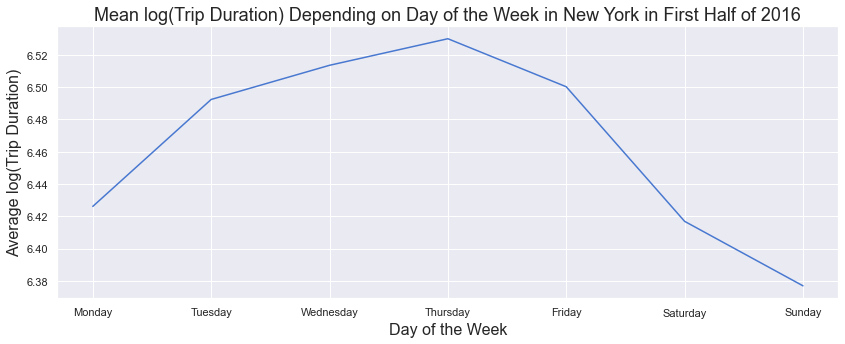

In [18]:
log_plot_day_week =  train_df_0.groupby(['day_name']).mean()[['log_trip_duration']].reset_index()
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
log_plot_day_week = log_plot_day_week.set_index('day_name').reindex(days_ordered).reset_index()

plt.figure(figsize = (14, 5))
ax = plt.subplot()
plt.plot(log_plot_day_week.day_name, log_plot_day_week.log_trip_duration)
ax.set_xticks(range(0, 7))
plt.title('Mean log(Trip Duration) Depending on Day of the Week in New York in First Half of 2016', fontsize=18)
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Average log(Trip Duration)', fontsize=16)

plt.show()

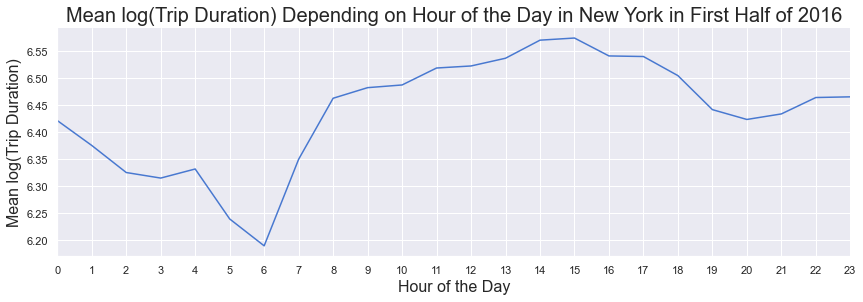

In [19]:
log_plot_hour_day = train_df_0.groupby(['hour_of_day']).mean()[['log_trip_duration']].reset_index()

h = sns.relplot(data=log_plot_hour_day, x="hour_of_day", y="log_trip_duration", kind="line", height=4, aspect=3)

h.set(xticks=[i for i in range(24)], xlim=(0,23))
plt.title('Mean log(Trip Duration) Depending on Hour of the Day in New York in First Half of 2016', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Mean log(Trip Duration)', fontsize=16)

plt.show()

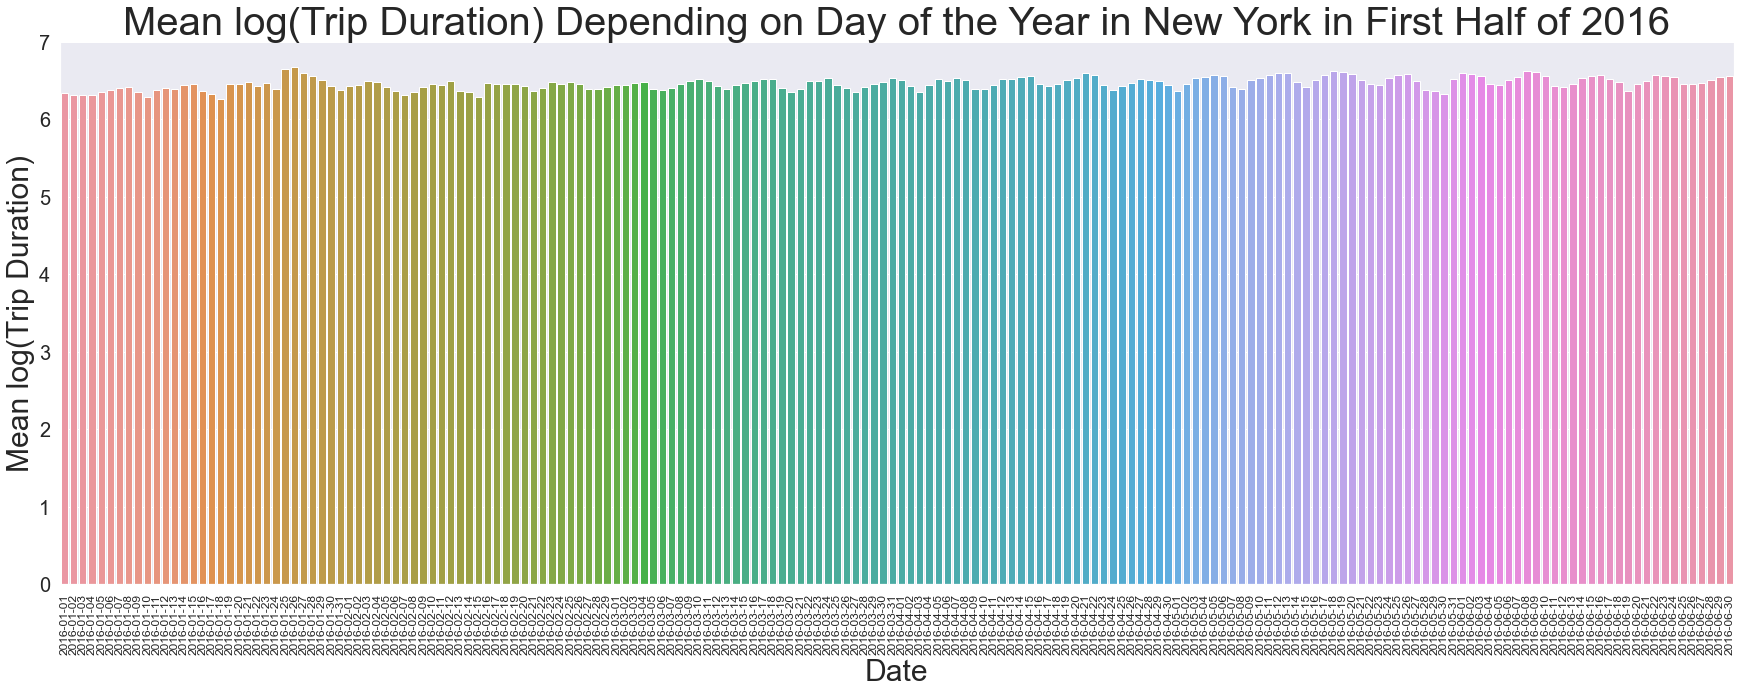

In [20]:
log_plot_day_year = train_df_0.groupby(train_df_0['pickup_datetime'].dt.date).mean()[['log_trip_duration']].reset_index()

plt.figure(figsize=(30, 10))
ax = plt.subplot()
sns.barplot(x = 'pickup_datetime', y = 'log_trip_duration', data = log_plot_day_year)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=20)
plt.title('Mean log(Trip Duration) Depending on Day of the Year in New York in First Half of 2016', fontsize=40)
plt.ylabel('Mean log(Trip Duration)', fontsize=30)
plt.xlabel('Date', fontsize=30)
ax.set_xticklabels(log_plot_day_year.pickup_datetime)

plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Похожими графиками оказались зависимость таргета от дня недели и от часа в сутках, что и не удивительно, чем больше количество поездок на такси, тем больше загруженность дорог. Такая зависимость характерна для любого транспорта. Чем больше транспорта на дороге, тем больше загруженность дорог, и тем дольше занимает поездка из точки А в точку Б.

На графике зависимости даты поездки и таргета нет таких аномальных периодов. Их нет потому что время в дороге не зависит от общего количества поездок на такси в этот день. Именно поэтому на графике мы не видим этих аномальных периодов. Впрочем, на графике также не заметна какая-либо взаимосвязь между датой в году и таргетом.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [21]:
# (╮°-°)┳┳ 

# Мы уже успели добавить такие признаки, когда стоили графики

# (╯ ° □ °) ╯ (┻━┻)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: Категориальные: День недели, Месяц, Час. Так как каждое из значений признака встречается часто у объектов выборки, и последовательность данных признаков на целевую переменную не влияет линейно, то имеет смысл такие признаки закодировать.

Бинарные: Является ли период аномальным

Численные: Номер дня в году можно закодировать как категориальный, однако номер дня в году может принимать намного больше разных значений, чем другие категориальные признаки. В таком случае признаки будут сильно разреженными. Так как данный признак не обладает какой-то очевидной зависимостью отличной от линейной от целевой переменной, то линейная модель может не плохо описать такую зависимость. Более того, если мы закодируем номер дня, то мы не сможем предсказывать зависимость между днем в году и целевой переменной в те дни, которые у нас ранее не встречались. Например, во вторую половину года.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [22]:
# Так как не сказано с какими данными работать, то вернемся к основному датафрему, закодируем признаки там, 
# а потом опять разобьем выборку на обучающую и тестовую 
from sklearn.preprocessing import OneHotEncoder, StandardScaler

enc = OneHotEncoder(drop='first', sparse=False)
# Дни недели
day_of_week = enc.fit_transform(df.day_name.values.reshape(-1, 1))
hot_day_of_week = pd.DataFrame(day_of_week, columns=['day=' + str(i+2) for i in range(day_of_week.shape[1])])

# Месяцы
month = enc.fit_transform(df.month_name.values.reshape(-1, 1))
hot_month = pd.DataFrame(month, columns=['month=' + str(i+2) for i in range(month.shape[1])])

# Час суток
hour = enc.fit_transform(df.hour_of_day.values.reshape(-1, 1))
hot_hour = pd.DataFrame(hour, columns=['hour=' + str(i+1) for i in range(hour.shape[1])])

df = pd.concat([df, hot_day_of_week, hot_month, hot_hour], axis=1)

# Отмасштабируем признаки
scaler = StandardScaler()
day = scaler.fit_transform(df.day_number.values.reshape(-1, 1))
df['day_scaled'] = day

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Можно и через iloc, но так меньше шансов запутаться и случаной не включить один из признаков
features_0 = df.drop(columns = ['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                                'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
                                'day_name', 'month_name', 'hour_of_day', 'day_number'])

target_0 = df.log_trip_duration

train_features_0, test_features_0, train_target_0, test_target_0 = train_test_split(features_0, 
                                                                                    target_0, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

rdg_0 = Ridge(alpha=1.0)
rdg_0.fit(train_features_0, train_target_0)
predict_0 = rdg_0.predict(test_features_0)

ridge_score_0 = rdg_0.score(test_features_0, test_target_0)
MSE_ridge_0 = mean_squared_error(test_target_0, predict_0)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_0, MSE_ridge_0))

R^2 = 0.017957348585394772, MSE for Ridge = 0.623370583281631


Итак, выделенные признаки совсем не объясняют целевую переменную, однако MSE немного сдвинулось в сторону уменьшения. Маленький шаг для функции потерь - большой шаг для человечества.

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [24]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [25]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [26]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: На карте выделяются две точки, которые находятся дальше всех от Манхэттена, это два аэропорта - Newark Liberty International Airport, John F. Kennedy International Airport

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [27]:
# jupyter тут тоже выдает ошибки, если это не сделано ранее, необходимо:
import warnings
warnings.filterwarnings('ignore')

# Источник знаний https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df.loc[:, 'distance_haversine'] = haversine_array(df['pickup_latitude'].values, 
                                                  df['pickup_longitude'].values, 
                                                  df['dropoff_latitude'].values, 
                                                  df['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [28]:
df.loc[:, 'log_distance_haversine'] = np.log(haversine_array(df['pickup_latitude'].values, 
                                                             df['pickup_longitude'].values, 
                                                             df['dropoff_latitude'].values, 
                                                             df['dropoff_longitude'].values))
# Поскольку оказалось, что поездка может закончиться там же, где и началась, то необходимо обрабатывать -inf, 
# пусть тогда нулевое расстояние равняется 1 метру
df.log_distance_haversine = df.log_distance_haversine.apply(lambda x: np.log(0.001) if x == np.NINF else x)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [29]:
df[['log_trip_duration', 'distance_haversine', 'log_distance_haversine']].corr()

,log_trip_duration,distance_haversine,log_distance_haversine
log_trip_duration,1.000000,0.573595,0.722120
distance_haversine,0.573595,1.000000,0.683736
log_distance_haversine,0.722120,0.683736,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

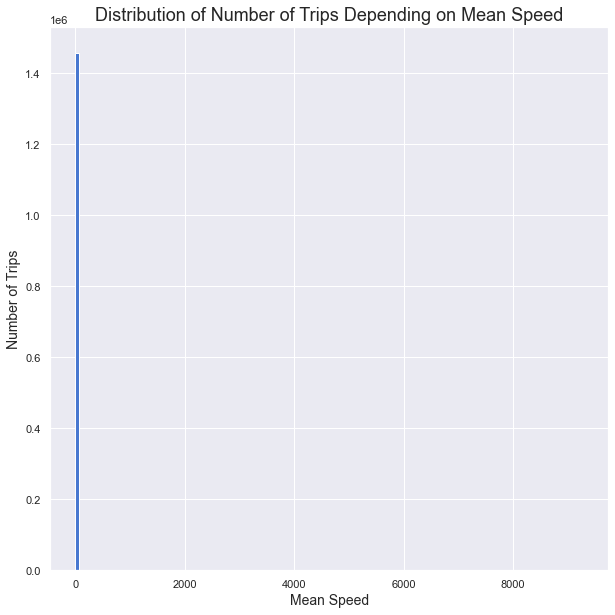

In [30]:
# Востановим значения, если оказалось, что они нужны
df['trip_duration'] = np.exp(df.log_trip_duration) - 1

df['mean_speed'] = df.distance_haversine / (df.trip_duration/3600)

plt.hist(df.mean_speed.values, bins=150)
plt.xlabel('Mean Speed', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.title('Distribution of Number of Trips Depending on Mean Speed', fontsize=18)

plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

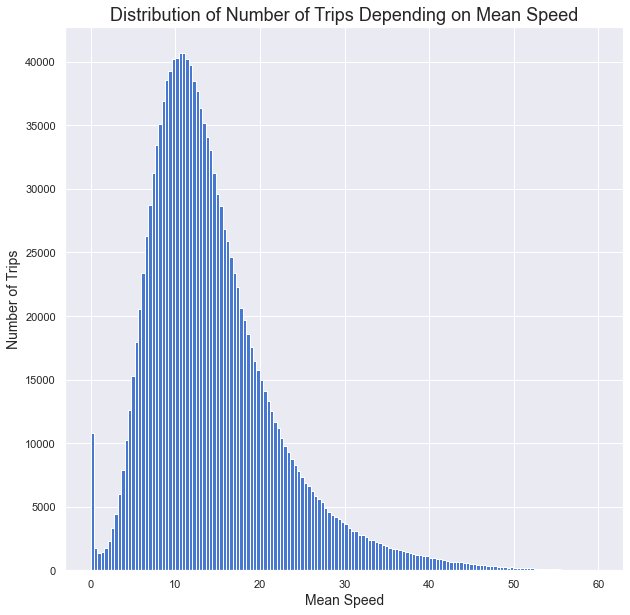

In [31]:
# Построим график с фильтром, очевидно, что в городе средняя скорость вряд ли может превышать 50-60 км\ч
plt.hist(df.mean_speed[df['mean_speed'] < 60].values, bins=150)
plt.xlabel('Mean Speed', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.title('Distribution of Number of Trips Depending on Mean Speed', fontsize=18)

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

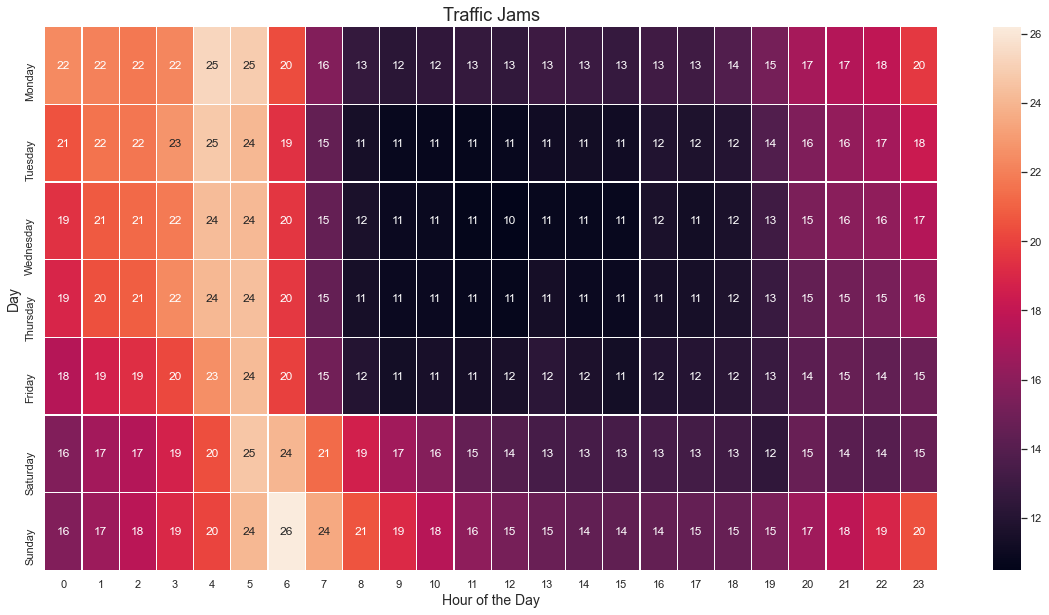

In [32]:
heat_group = df.groupby(['day_name', 'hour_of_day']).mean()[['mean_speed']].reset_index()
heat_group = heat_group.pivot('day_name', 'hour_of_day', 'mean_speed').reset_index()
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_group = heat_group.set_index('day_name').reindex(days_ordered)

# Спасибо официальная документация :D https://seaborn.pydata.org/generated/seaborn.heatmap.html

plt.figure(figsize=(20, 10))
sns.heatmap(heat_group, annot=True, linewidths=.2)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Day', fontsize=14)
plt.title('Traffic Jams', fontsize=18)

plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Значение скорости является синтетическим признаком, который основан на очень многих параметрах, таких как загруженность дороги, траектория маршрута, которые в свою очередь зависят от других параметров. Необходимо искать первичные параметры и строить предсказание уже на них. Скорость в тесте может отличаться от обучающей выборки, а пробки скорее всего будут в то же время.

In [33]:
df.drop(columns=['mean_speed', 'trip_duration'], inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Минимальная скорость: Понедельник, вториник, среда, четверг, пятница - 8:00 - 19:00. Суббота - 13:00 - 19:00. В восресенье дорога более-менее свободная.

Максимальная скорость: Понедельник - 0:00 - 6:00, 23:00. Вторник, Среда, Четверг, Пятница - 0:00 - 6:00. Суббота - 3:00 - 7:00, Воскресенье - 3:00 - 8:00, 22:00 - 23:00

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [34]:
# Конструкция, конечно, несколько тяжеловата для чтения. Но по скорости выполнения намного лучше функции и apply

df['free_road'] = 0
df.free_road[((df.day_name.isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (df.hour_of_day <= 6)) \
             | ((df.day_name == 'Monday') & (df.hour_of_day == 23)) | ((df.day_name.isin(['Saturday', 'Sunday'])) \
             & (df.hour_of_day >= 3) & (df.hour_of_day <= 7)) | ((df.day_name == 'Sunday') \
             & (df.hour_of_day.isin([8, 22, 23])))] = 1

df['traffic'] = 0
df.traffic[((df.day_name.isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (df.hour_of_day >= 8) & \
            (df.hour_of_day <= 19)) | ((df.day_name == 'Saturday') & (df.hour_of_day >= 13) & (df.hour_of_day <= 19))] = 1

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [35]:
df['aeroport_start'] = 0 
df.aeroport_start[((df.pickup_latitude >= 40.668702) & (df.pickup_latitude <= 40.709794) & #Newark_International
                  (df.pickup_longitude >= -74.206440) & (df.pickup_longitude <= -74.159022)) | \
                  ((df.pickup_latitude >= 40.638432) & (df.pickup_latitude <= 40.677599) & #Kennedy_International_Airport
                  (df.pickup_longitude >= -73.836839) & (df.pickup_longitude <= -73.756805))] = 1

df['aeroport_end'] = 0 
df.aeroport_end[((df.dropoff_latitude >= 40.668702) & (df.dropoff_latitude <= 40.709794) & #Newark_International
                (df.dropoff_longitude >= -74.206440) & (df.dropoff_longitude <= -74.159022)) | \
                ((df.dropoff_latitude >= 40.638432) & (df.dropoff_latitude <= 40.677599) & #Kennedy_International_Airport
                (df.dropoff_longitude >= -73.836839) & (df.dropoff_longitude <= -73.756805))] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

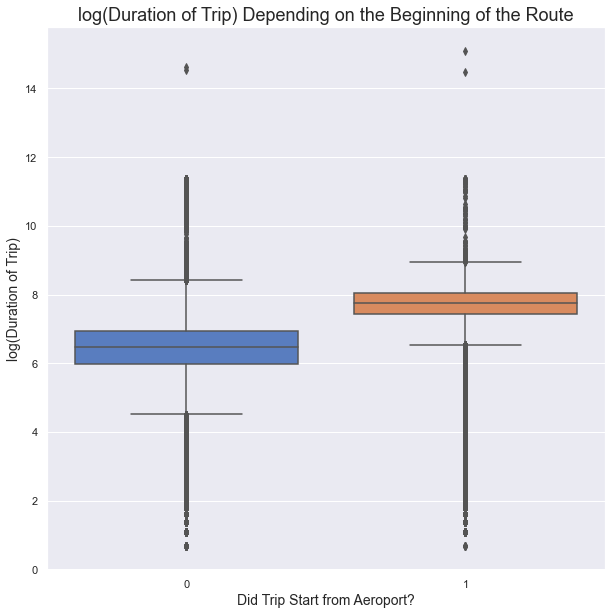

In [36]:
sns.boxplot(data = df, x = 'aeroport_start', y = 'log_trip_duration')
plt.xlabel('Did Trip Start from Aeroport?', fontsize=14)
plt.ylabel('log(Duration of Trip)', fontsize=14)
plt.title('log(Duration of Trip) Depending on the Beginning of the Route', fontsize=18)

plt.show()

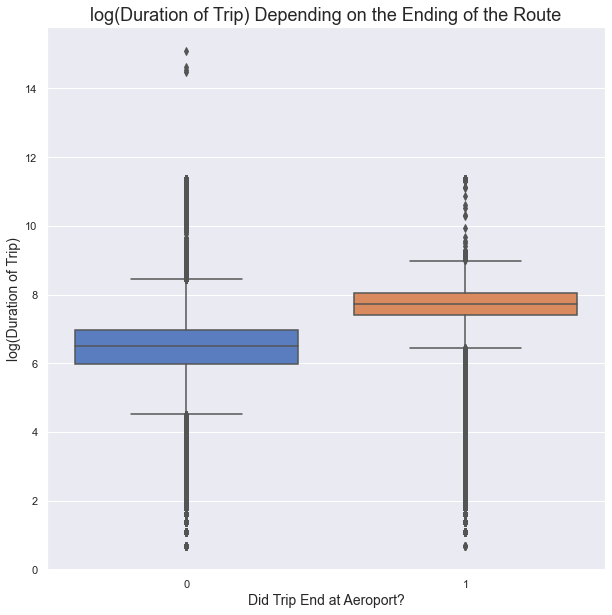

In [37]:
sns.boxplot(data = df, x = 'aeroport_end', y = 'log_trip_duration')
plt.xlabel('Did Trip End at Aeroport?', fontsize=14)
plt.ylabel('log(Duration of Trip)', fontsize=14)
plt.title('log(Duration of Trip) Depending on the Ending of the Route', fontsize=18)

plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Таргет при поездке из аэропорта или в аэропорт имеет другое распределение нежели средняя поездка в обычном режиме, то возможно данные признаки позволят уменьшить показатель функции потерь.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial.distance import cdist

# Спасибо огромное интернету за его существование. Источник знаний:
# https://ru.stackoverflow.com/questions/1161594/Разбиение-области-на-ячейки-и-присвоение-меток-с-началом-и-концом

COL_NAMES = dict(
    pick_lat="pickup_latitude",
    pick_lon="pickup_longitude",
    drop_lat="dropoff_latitude",
    drop_lon="dropoff_longitude"
)

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        self.location_mh = loc
        self.col = col
        self.row = row
        self.col_names = col_names
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        self.lat_min, self.lat_max = loc[:, 0].min(), loc[:, 0].max()
        self.lon_min, self.lon_max = loc[:, 1].min(), loc[:, 1].max()
        
    def fit(self):
        self.walls = [(self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col, \
              (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row]
        self.circles_loc = np.array([(((self.location_mh[:, 0].min() + i * (self.walls[0] / 2))), \
                               (self.location_mh[:, 1].min() + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])
        return self.circles_loc    
        
    def get_sector_idx(self, X):
        self.circles_loc = self.fit()
        pickup_idx = cdist(X.loc[:, [self.pick_lat, self.pick_lon]],
                           self.circles_loc).argmin(axis=1)
        dropoff_idx = cdist(X.loc[:, [self.drop_lat, self.drop_lon]],
                            self.circles_loc).argmin(axis=1)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max \
               and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max \
               and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1
        return pickup_idx, dropoff_idx

    def transform(self, X):
        return self.get_sector_idx(X)

In [39]:
# Укажим облась большого квадрата
mh = np.array([[40.707518, -74.029398],
              [40.707518, -73.927090],
              [40.794264, -73.927090],
              [40.794264, -74.029398]])
# Разобьем большой квадрат на 20 зон + 1 за пределами
a = MapGridTransformer(mh, 5, 4)

In [40]:
zones = a.transform(df)
zones = np.array(zones).transpose()
zone_df = pd.DataFrame(zones, columns=['start_trip', 'end_trip'])
df = df.merge(zone_df, how='left', left_index=True, right_index=True)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [41]:
# Здесь мы не будем пользоваться one-hot-кодированием, в 15 задании мы будем по-другому использовать признаки территории.
# Чтобы не добавлять новые 20 признаков, а потом их не удалять этого делать не будем

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

log_distance_haversine = scaler.fit_transform(df.log_distance_haversine.values.reshape(-1, 1))
df['log_distance_haversine_scaled'] = log_distance_haversine

start_trip = scaler.fit_transform(df.start_trip.values.reshape(-1, 1))
df['start_trip_scaled'] = start_trip

end_trip = scaler.fit_transform(df.end_trip.values.reshape(-1, 1))
df['end_trip_scaled'] = end_trip

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

features_1 = df.drop(columns = ['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                                'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
                                'day_name', 'month_name', 'hour_of_day', 'day_number', 'distance_haversine', 
                                'start_trip', 'end_trip', 'log_distance_haversine'])
target_1 = df.log_trip_duration

train_features_1, test_features_1, train_target_1, test_target_1 = train_test_split(features_1, 
                                                                                    target_1, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

rdg_1 = Ridge(alpha=1.0)
rdg_1.fit(train_features_1, train_target_1)
predict_1 = rdg_1.predict(test_features_1)

ridge_score_1 = rdg_1.score(test_features_1, test_target_1)
MSE_ridge_1 = mean_squared_error(test_target_1, predict_1)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_1, MSE_ridge_1))

R^2 = 0.5704472951148547, MSE for Ridge = 0.2726668946697369


Результат уже существенно отличается от нашей первой попытки. Продолжим узучать признаки!

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: `vendor_id` - идентифицирует поставщика. Поставщик может осуществлять свою деятельность в различных регионах, и как следствие может отличаться длительность поездки в том или ином регионе.

`passenger_count` -  число пассажиров может влиять на продолжительность поездки, разная загруженность такси может повлиять на продолжительность следующими факторами: разное число людей может путешествовать на разные дистанции; может меняться скорость загрузки и выгрузки такси.

`store_and_fwd_flag` - хранит признак передачи сообщения "хранилась ли запись поездки в памяти транспортного средства перед отправкой поставщику". Возможно, если автомобиль был вне зоны доступа, он находился далеко от города. А значит автомобиль мог проехать дальнее расстояние до этой точки. Как следствие длительность поездки может отличаться.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [43]:
print("""Unique values for vendor_id - {}
Unique values for passenger_count - {}
Unique values for store_and_fwd_flag - {}""".format(df.vendor_id.nunique(), 
                                                    df.passenger_count.nunique(), 
                                                    df.store_and_fwd_flag.nunique()))

Unique values for vendor_id - 2
Unique values for passenger_count - 10
Unique values for store_and_fwd_flag - 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

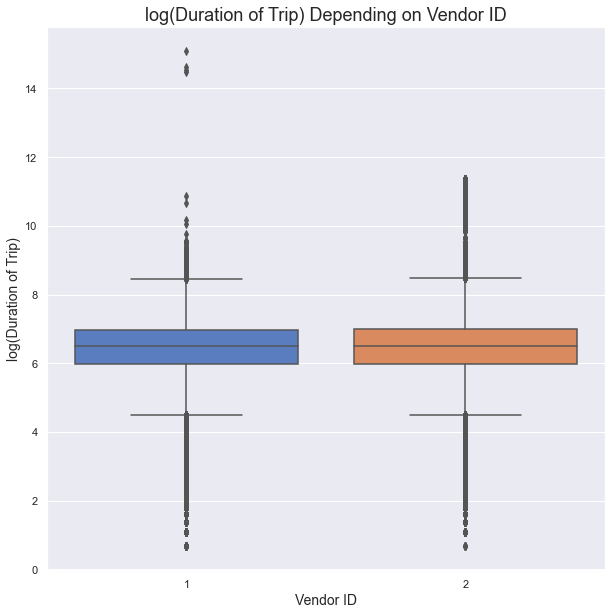

In [44]:
sns.boxplot(data = df, x = 'vendor_id', y = 'log_trip_duration')
plt.xlabel('Vendor ID', fontsize=14)
plt.ylabel('log(Duration of Trip)', fontsize=14)
plt.title('log(Duration of Trip) Depending on Vendor ID', fontsize=18)

plt.show()

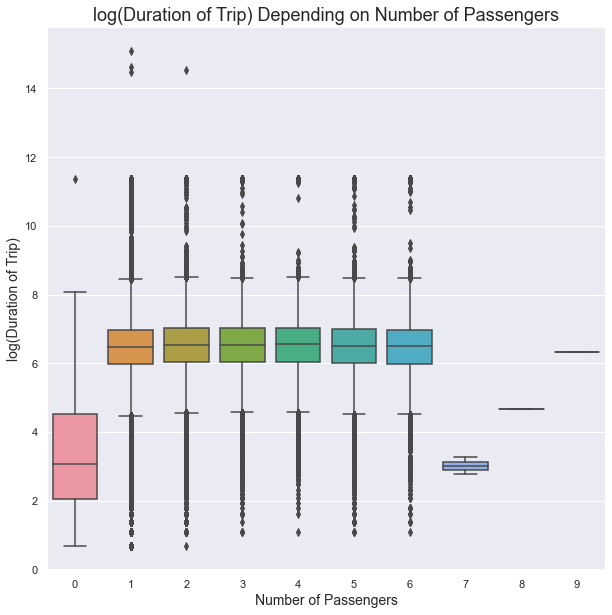

In [45]:
sns.boxplot(data = df, x = 'passenger_count', y = 'log_trip_duration')
plt.xlabel('Number of Passengers', fontsize=14)
plt.ylabel('log(Duration of Trip)', fontsize=14)
plt.title('log(Duration of Trip) Depending on Number of Passengers', fontsize=18)

plt.show()

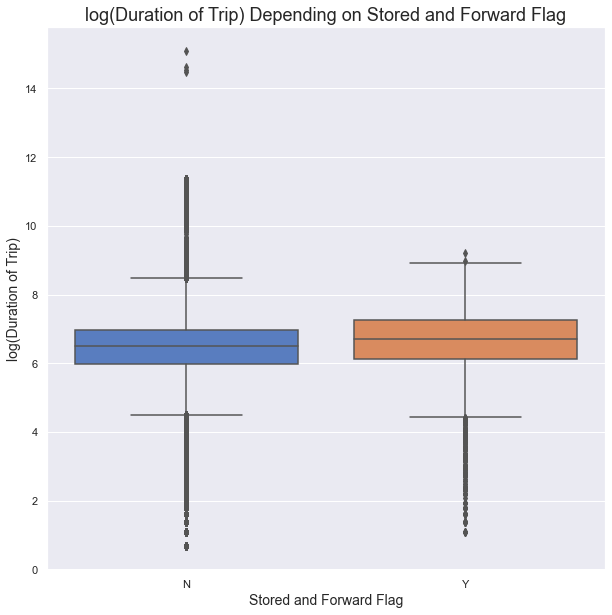

In [46]:
sns.boxplot(data = df, x = 'store_and_fwd_flag', y = 'log_trip_duration')
plt.xlabel('Stored and Forward Flag', fontsize=14)
plt.ylabel('log(Duration of Trip)', fontsize=14)
plt.title('log(Duration of Trip) Depending on Stored and Forward Flag', fontsize=18)

plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [47]:
df.vendor_id = df.vendor_id.apply(lambda x: 0 if x == 1 else 1)
df.store_and_fwd_flag = df.store_and_fwd_flag.apply(lambda x: 0 if x == 'N' else 1)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Полезным признаком скорее всего будет количество пассажиров, поскольку при количестве 0, 7-9 совсем другие распределения отличные от обычных (при количестве пассажиров 2-6). Однако 7-9 пассажиров скорее всего выброс, т.к. данное количество людей не поместиться даже в минивен.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [48]:
# Здесь мы не будем пользоваться one-hot-кодированием, в 15 задании мы будем по-другому использовать признаки территории.
# Чтобы не добавлять новые 20 признаков, а потом их не удалять этого делать не будем

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

passenger_count = scaler.fit_transform(df.passenger_count.values.reshape(-1, 1))
df['passenger_count_scaled'] = passenger_count

In [49]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

features_2 = df.drop(columns = ['id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                                'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration','day_name', 'month_name', 
                                'hour_of_day', 'day_number', 'distance_haversine', 'start_trip', 'end_trip',
                                'log_distance_haversine'])
target_2 = df.log_trip_duration

train_features_2, test_features_2, train_target_2, test_target_2 = train_test_split(features_2, 
                                                                                    target_2, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

rdg_2 = Ridge(alpha=1.0)
rdg_2.fit(train_features_2, train_target_2)
predict_2 = rdg_2.predict(test_features_2)

ridge_score_2 = rdg_2.score(test_features_2, test_target_2)
MSE_ridge_2 = mean_squared_error(test_target_2, predict_2)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_2, MSE_ridge_2))

R^2 = 0.570770978296493, MSE for Ridge = 0.2724614305043611


In [50]:
significancy = dict(features = features_2.columns, 
                    coef = rdg_2.coef_)
significancy_df = pd.DataFrame(data=significancy)
significancy_df['abs_coef'] = abs(significancy_df.coef)
significancy_df.sort_values('abs_coef', ascending=False)

,features,coef,abs_coef
43,log_distance_haversine_scaled,0.568980,0.568980
40,traffic,0.228536,0.228536
2,winter_anomaly,0.221539,0.221539
39,free_road,-0.181076,0.181076
19,hour=5,-0.179040,0.179040
3,may_anomaly,-0.140249,0.140249
33,hour=19,-0.135592,0.135592
20,hour=6,-0.110675,0.110675
16,hour=2,-0.106288,0.106288
4,day=2,-0.104895,0.104895


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Тест показал,что самым малозначимым признаком из 3-х оказался "количество пассажиров". Удалим этот признак. Остальные пока оставим.

In [51]:
df.drop(columns = ['passenger_count', 'passenger_count_scaled'], inplace = True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [52]:
# Еще раз разделим выборку на обучающую и тестовую 
from sklearn.model_selection import train_test_split

train_df, test_df= train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 98)

In [53]:
# Поскольку данных у нас достаточно много, то обрежим концы нашей выборки по 0.5% с каждой стороны (снизу чуть меньше)
train_df = train_df.loc[train_df['distance_haversine'] <= train_df.loc[:, 'distance_haversine'].quantile(0.995)]
train_df = train_df.loc[train_df['distance_haversine'] >= train_df.loc[:, 'distance_haversine'].quantile(0.005)]

train_df = train_df.loc[train_df['log_trip_duration'] <= train_df.loc[:, 'log_trip_duration'].quantile(0.995)]
train_df = train_df.loc[train_df['log_trip_duration'] >= train_df.loc[:, 'log_trip_duration'].quantile(0.005)]

# Сделаем небольшой финт, востановим изначальный таргет (время поездки) и посчитаем заново среднюю скорость, 
# все что окажется больше 80 км\ч удалим из выборки + удалим все данные которые начались и закончились в городе 
# и у которых средняя скорость больше 55 км\ч (в Нью Йорке во многих районах окграничение в 30 миль\ч, 
# за исключением магистралей). Еще и удалим дубликаты в данных

train_df['trip_duration'] = np.exp(train_df.log_trip_duration) - 1
train_df['mean_speed'] = train_df.distance_haversine / (train_df.trip_duration/3600)

train_df.drop(train_df[train_df['mean_speed'] > 80].index, inplace=True)

train_df.drop(train_df[(train_df['mean_speed'] > 55) & (train_df['start_trip'] != -1) & \
                       (train_df['end_trip'] != -1)].index, inplace = True)

train_df.drop_duplicates(inplace = True)

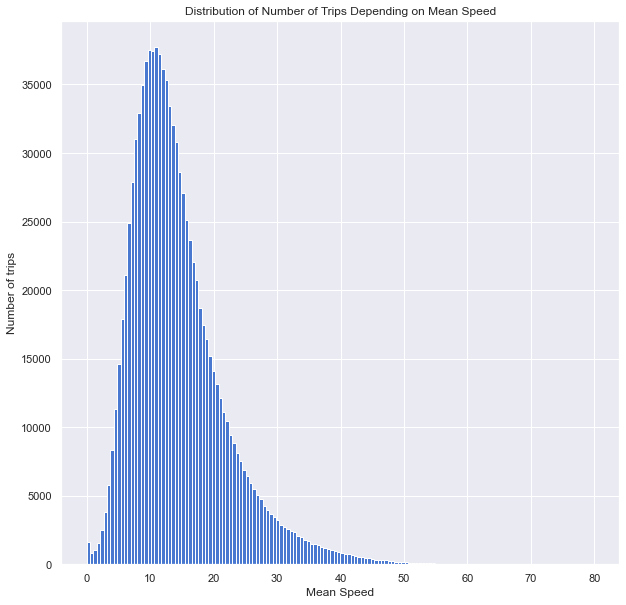

In [54]:
# посмотрим как мы справились и удалим признаки, которые больше не нужны
plt.hist(train_df.mean_speed.values, bins=150)
plt.xlabel('Mean Speed')
plt.ylabel('Number of trips')
plt.title('Distribution of Number of Trips Depending on Mean Speed')

plt.show()

train_df.drop(columns = ['trip_duration', 'mean_speed'], inplace = True)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [55]:
# поскольку с загруженностью дороги хорошо справляются признаки 'free_road', 'traffic' - удалим все признаки связанные с
# часом суток. Достаточно редко встречается признак, характеризующий поездку из и в аэропорт. ДОбавим его в состав 
# 'start_trip' и 'end_trip' со значением - 2. Заодно почисти признаки, которые не используем

columns = [9, 10, 11, 12] + [i for i in range(26, 52)] + [54, 55, 56, 57]

train_df.start_trip[train_df.aeroport_start == 1] = -2 
train_df.end_trip[train_df.aeroport_end == 1] = -2 

train_df.drop(train_df.columns[columns], axis=1, inplace=True)

# Теперь тоже самое для теста

test_df.start_trip[test_df.aeroport_start == 1] = -2 
test_df.end_trip[test_df.aeroport_end == 1] = -2 

test_df.drop(test_df.columns[columns], axis=1, inplace=True)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [56]:
from sklearn.linear_model import Ridge

indexes = [1, 7] + [i for i in range(9, 27)] 
train_features_3 = train_df.iloc[:, indexes]
test_features_3 = test_df.iloc[:, indexes]
train_target_3 = train_df.iloc[:, 8]
test_target_3 = test_df.iloc[:, 8]

rdg_3 = Ridge(alpha=1.0)
rdg_3.fit(train_features_3, train_target_3)
predict_3 = rdg_3.predict(test_features_3)

ridge_score_3 = rdg_3.score(test_features_3, test_target_3)
MSE_ridge_3 = mean_squared_error(test_target_3, predict_3)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_3, MSE_ridge_3))

R^2 = 0.5426155193019833, MSE for Ridge = 0.2899269562170036


Этого следовало ожидать. Модель сейчас дает более адекватные предсказания, но в тестовой выборке остались выбросы. Чистка обучающей выборки привела к ухудшению качества на тесте. Однако модель получилась более разумной и интерпретируемой. Просто попробуем посмотреть результат, если бы в тесте не было выбросов.

In [57]:
predict_3 = rdg_3.predict(train_features_3)
ridge_score_3 = rdg_3.score(train_features_3, train_target_3)
MSE_ridge_3 = mean_squared_error(train_target_3, predict_3)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_3, MSE_ridge_3))

R^2 = 0.6532578964378084, MSE for Ridge = 0.1746587944801852


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [58]:
#  Очистка датасета от выбросов привела к ухудшению качества на тесте. Вернемся к начальному датасету.
indexes = [1, 7] + [i for i in range(13, 49)] + [i for i in range(52, 56)] + [58, 59, 60]

print("""Сейчас у нас всего {} признак, при этом мы выделили на текущий момент 3 категориальных признака: День недели, 
Месяц, Час суток. Напомню, что признак територии решили не кодировать, так как в 15 задании у нас будет другой способ 
подхода к этому признаку. Тогда количество новых признаков возникших при кодировании - {}.
Количество признаков до кодирования - {}.
Количество признаков после кодирования - {}.
Количество признаков используемых для построения модели - {}.""".format(len(df.iloc[1, :]), (len(df.iloc[1, :])-6-5-23), 
                                                      (6+5+23), len(df.iloc[1, :]), len(indexes)))

# Дни недели - 6 признов
# Месяцы - 5 месяцев
# Час суток - 23 признака

Сейчас у нас всего 61 признак, при этом мы выделили на текущий момент 3 категориальных признака: День недели, 
Месяц, Час суток. Напомню, что признак територии решили не кодировать, так как в 15 задании у нас будет другой способ 
подхода к этому признаку. Тогда количество новых признаков возникших при кодировании - 27.
Количество признаков до кодирования - 34.
Количество признаков после кодирования - 61.
Количество признаков используемых для построения модели - 45.


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [59]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

features_4 = df.drop(columns = ['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                                'dropoff_latitude', 'log_trip_duration','day_name', 'month_name', 'hour_of_day', 
                                'day_number', 'distance_haversine', 'start_trip', 'end_trip', 'log_distance_haversine'])
target_4 = df.log_trip_duration

train_features_4, test_features_4, train_target_4, test_target_4 = train_test_split(features_4, 
                                                                                    target_4, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

lasso = linear_model.Lasso(alpha=1)
lasso.fit(train_features_4, train_target_4)
predict_4 = lasso.predict(test_features_4)

lasso_score = lasso.score(test_features_4, test_target_4)
MSE_lasso = mean_squared_error(test_target_4, predict_4)

print('R^2 = {}, MSE for Lasso = {}'.format(lasso_score, MSE_lasso))

R^2 = -2.2479428603006113e-06, MSE for Lasso = 0.634770784838248


In [60]:
lasso.coef_
np.count_nonzero(lasso.coef_)

0

При стандартном alpha модель зануляет все коэфициенты. Необходимо подбирать alpha на валидационной выборке

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [61]:
# оценим наилучший параметр alpha путем кросс-валидации. Параметр кросс-валидации поставим равный 5. 
# в таком случае выборка разобьется 5 раз в соотношении 4:1

from sklearn.model_selection import GridSearchCV

parametrs = {'alpha': np.logspace(np.log(0.0001), np.log(1), num = 10, base = np.e)}

Lasso_grid = linear_model.Lasso()
grid_lasso = GridSearchCV(Lasso_grid, parametrs, cv=5)
grid_lasso.fit(train_features_4, train_target_4)

print('Наилучший параметр alpha для модели с регуляризацией L1 - {}.'.format(round(grid_lasso.best_params_['alpha']), 5))

Наилучший параметр alpha для модели с регуляризацией L1 - 0.0.


In [62]:
lasso_df = pd.DataFrame(data = grid_lasso.cv_results_)
lasso_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.263300,1.534582,0.143224,0.021052,0.0001,{'alpha': 0.00010000000000000014},5.658246e-01,0.566127,5.682756e-01,0.567190,5.711694e-01,0.567717,0.001930,1
1,6.112137,0.529601,0.142634,0.014287,0.000278256,{'alpha': 0.000278255940220713},5.656841e-01,0.565959,5.681404e-01,0.567019,5.710219e-01,0.567565,0.001934,2
2,3.635180,0.392660,0.161192,0.016275,0.000774264,{'alpha': 0.0007742636826811277},5.649289e-01,0.565147,5.673783e-01,0.566175,5.702459e-01,0.566775,0.001941,3
3,2.401467,0.219977,0.146244,0.022026,0.00215443,{'alpha': 0.002154434690031885},5.626742e-01,0.562766,5.650029e-01,0.563827,5.679781e-01,0.564450,0.001956,4
4,2.342152,0.415166,0.168982,0.037230,0.00599484,{'alpha': 0.005994842503189412},5.597522e-01,0.559466,5.618336e-01,0.560879,5.648505e-01,0.561356,0.001940,5
5,1.814488,0.315477,0.120097,0.012701,0.016681,{'alpha': 0.01668100537200059},5.532146e-01,0.552788,5.555594e-01,0.554529,5.582893e-01,0.554876,0.001968,6
6,1.626346,0.204662,0.115298,0.014576,0.0464159,{'alpha': 0.04641588833612778},5.282691e-01,0.527355,5.306051e-01,0.529142,5.325049e-01,0.529575,0.001815,7
7,1.363564,0.034763,0.105916,0.012556,0.129155,{'alpha': 0.12915496650148833},4.939687e-01,0.492803,4.960111e-01,0.493338,4.966263e-01,0.494549,0.001504,8
8,1.440523,0.065010,0.111006,0.014207,0.359381,{'alpha': 0.3593813663804625},3.165660e-01,0.316261,3.175108e-01,0.315020,3.171624e-01,0.316504,0.000862,9
9,1.388695,0.113380,0.105212,0.018340,1,{'alpha': 1.0},-1.119390e-07,-0.000013,-4.484013e-07,-0.000017,-2.906886e-07,-0.000006,0.000007,10


In [63]:
parametrs = {'alpha': np.logspace(np.log(0.0001), np.log(1), num = 10, base = np.e)}

Ridge_grid = Ridge()
grid_ridge = GridSearchCV(Ridge_grid, parametrs, cv=5)
grid_ridge.fit(train_features_4, train_target_4)

print('Наилучший параметр alpha для модели с регуляризацией L2- {}.'.format(round(grid_ridge.best_params_['alpha']), 5))

Наилучший параметр alpha для модели с регуляризацией L2- 1.0.


In [64]:
ridge_df = pd.DataFrame(data = grid_ridge.cv_results_)
ridge_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.228018,0.129983,0.116803,0.015610,0.0001,{'alpha': 0.00010000000000000014},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,10
1,1.272913,0.166902,0.128097,0.023918,0.000278256,{'alpha': 0.000278255940220713},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,9
2,1.230292,0.076054,0.121938,0.015988,0.000774264,{'alpha': 0.0007742636826811277},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,8
3,1.430911,0.302744,0.140435,0.026534,0.00215443,{'alpha': 0.002154434690031885},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,7
4,1.666748,0.143829,0.169085,0.022159,0.00599484,{'alpha': 0.005994842503189412},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,6
5,1.221384,0.159779,0.111637,0.011824,0.016681,{'alpha': 0.01668100537200059},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,5
6,1.259945,0.191462,0.117084,0.011892,0.0464159,{'alpha': 0.04641588833612778},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,4
7,1.137637,0.033107,0.108591,0.005686,0.129155,{'alpha': 0.12915496650148833},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,3
8,1.216961,0.038722,0.109799,0.003307,0.359381,{'alpha': 0.3593813663804625},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,2
9,1.297946,0.223534,0.118594,0.026772,1,{'alpha': 1.0},0.565855,0.566166,0.568325,0.56724,0.571222,0.567761,0.001936,1


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [65]:
train_features_5, validation_features_5, train_target_5, validation_target_5 = train_test_split(train_features_4, 
                                                                                                train_target_4, 
                                                                                                train_size = 0.8, 
                                                                                                test_size = 0.2, 
                                                                                                random_state = 98)
lasso_MSE_list = []
lasso_alpha_list = []
lasso_non_zero = []
MSE_lasso_best = 0.634770784838248
for i in np.logspace(np.log(0.0001), np.log(1), num = 10, base = np.e):
    lasso = linear_model.Lasso(alpha=i)
    lasso.fit(train_features_5, train_target_5)
    predict_5 = lasso.predict(validation_features_5)
    MSE_lasso_2 = mean_squared_error(validation_target_5, predict_5)
    lasso_MSE_list.append(MSE_lasso_2)
    lasso_alpha_list.append(round(i, 5))
    lasso_non_zero.append(np.count_nonzero(lasso.coef_))

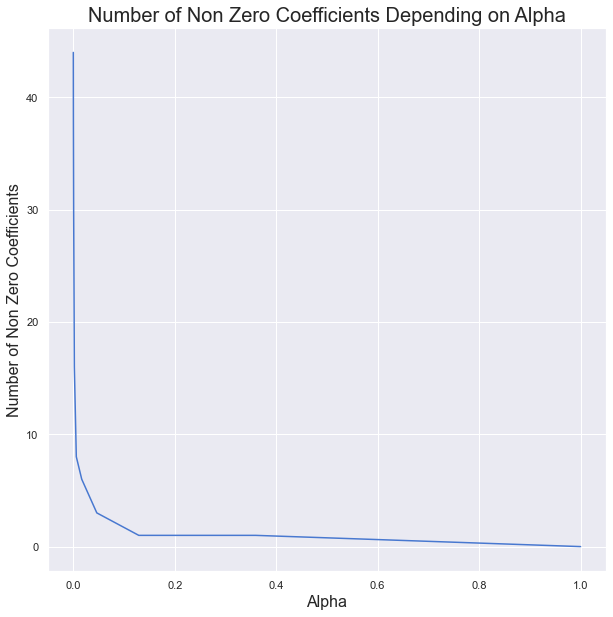

In [66]:
ax = plt.subplot()
plt.plot(lasso_alpha_list, lasso_non_zero)
plt.title('Number of Non Zero Coefficients Depending on Alpha', fontsize=20)
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('Number of Non Zero Coefficients', fontsize=16)


plt.show()

In [67]:
# поскольку по графику тяжело определить при определенном alpha точное значение признаков, посмотрим данные по таблице
non_zero = dict(alpha = lasso_alpha_list, 
                features_number = lasso_non_zero, 
                MSE = lasso_MSE_list)
lasso_decrease_features = pd.DataFrame(data=non_zero)
lasso_decrease_features

,alpha,features_number,MSE
0,0.00010,44,0.268748
1,0.00028,38,0.268857
2,0.00077,30,0.269360
3,0.00215,16,0.270799
4,0.00599,8,0.272710
5,0.01668,6,0.276927
6,0.04642,3,0.293114
7,0.12915,1,0.316492
8,0.35938,1,0.432630
9,1.00000,0,0.634482


In [68]:
downgrade = lasso_decrease_features.iloc[3, 2] - lasso_decrease_features.iloc[0, 2]
print('При уменьшении признаков вдвое функция ошибок возрастет на {}.'.format(downgrade))

При уменьшении признаков вдвое функция ошибок возрастет на 0.0020517117182002886.


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: Продолжительность поездки в разных районах Манхэттена может совершенно отличаться. Так, в Мидтаун скорее всего ездят по работе и вероятно продолжительность поездки не велика. А поездка за пределы Манхэттена диаметрально противоположная ситуация. Линейная модель не может получить такую информацию потому, что такая модель ищет в данных линейную зависимость. Например, в нашем случае, в порядковом номере маршрута она пытается определить, как непосредственно числовая последовательность от -1 до 100 влияет на целевую переменную. При этом всей совокупности маршрутов она может поставить только один "коэффициент влияния". По этой причине маршрут необходимо кодировать в разные признаки.

In [69]:
zones_trip = df.groupby(['start_trip', 'end_trip']).count()[['id']]
top_100_zones = zones_trip.sort_values('id', ascending=False).head(100).reset_index()

top_100_zones['route'] = [i for i in range(1, 101)]
top_100_zones.drop(columns = ['id'], inplace = True)

df = df.merge(top_100_zones, how='left', on=['start_trip', 'end_trip'])
df.route.fillna(-1, inplace=True)

In [70]:
# давайте сейчас удалим признаки, которые нам точно в дальнейшем не понадобятся 
df.drop(columns = ['day_name', 'month_name', 'hour_of_day', 'day_number',  
                    'start_trip_scaled', 'end_trip_scaled'], inplace = True)

In [71]:
from sklearn.preprocessing import OneHotEncoder

df1= df.copy()

enc = OneHotEncoder(drop='first', sparse=False)
# Маршрут
route = enc.fit_transform(df1.route.values.reshape(-1, 1))
hot_route = pd.DataFrame(route, columns=['route=' + str(i+1) for i in range(route.shape[1])])


df = pd.concat([df, hot_route], axis=1)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [72]:
target_6 = df.log_trip_duration
features_6 = df.drop(columns = ['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                                 'dropoff_latitude','start_trip', 'end_trip', 'log_trip_duration', 'route', 
                                 'log_distance_haversine'])

train_features_6, test_features_6, train_target_6, test_target_6 = train_test_split(features_6, 
                                                                                    target_6, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

rdg_6 = Ridge(alpha=1.0)
rdg_6.fit(train_features_6, train_target_6)
predict_6 = rdg_6.predict(test_features_6)

ridge_score_6 = rdg_6.score(test_features_6, test_target_6)
MSE_ridge_6 = mean_squared_error(test_target_6, predict_6)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_6, MSE_ridge_6))

R^2 = 0.6058246540979757, MSE for Ridge = 0.25021043122336345


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

**Ответ**: Большинство город имеют застройку, продиктованную теми или иными условиями, какие это условия и почему застройка имеет разную форму мы не будем вникать. Но так произошло, что Манхэттен имеет достаточно редкую форму планировки. У нас такая планировка называется шахматной или прямоугольной. В таком городе большинство улиц располагаются друг к другу под прямым углом. В связи с этим, точнее расстояние из точки А в точку Б (в пределах города) должно аппроксимировать так называемое махэттенское расстояние.

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

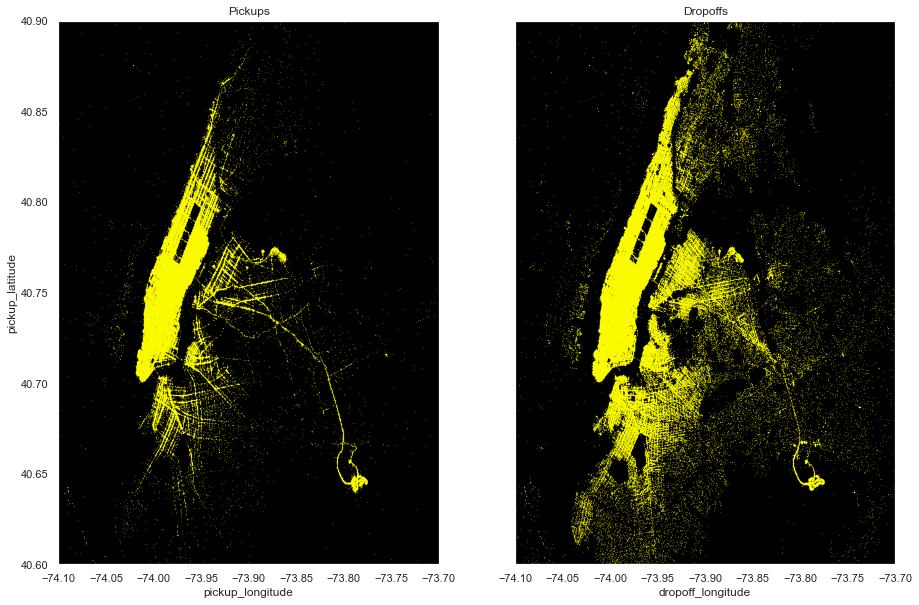

In [73]:
# за график спасибо https://www.kaggle.com/poonaml/last-cab-to-new-york-animated-heatmap-trips-folium

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='yellow', s=.02, alpha=.6, 
        subplots=True, ax=ax1, xlim = (-74.1, -73.7), ylim = (40.6, 40.9), grid = False)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', color='yellow', s=.02, alpha=.6, 
        subplots=True, ax=ax2, xlim = (-74.1, -73.7), ylim = (40.6, 40.9), grid = False)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

In [74]:
def rotate(lng1, lat1, lng2, lat2, angle):
    point = (-73.9, 40.75)
    
    x1, y1, x2, y2 =  lng1, lat1, lng2, lat2,
    px, py = point

    qx1 = x1 + np.cos(angle) * (px - x1) - np.sin(angle) * (py - y1)
    qy1 = y1 + np.sin(angle) * (px - x1) * np.cos(np.radians(x1)) + np.cos(angle) * (py - y1) * np.cos(np.radians(x1))
    qx2 = x2 + np.cos(angle) * (px - x2) - np.sin(angle) * (py - y2)
    qy2 = y2 + np.sin(angle) * (px - x2) * np.cos(np.radians(x1)) + np.cos(angle) * (py - y2) * np.cos(np.radians(x1))
    return   qx1, qy1, qx2, qy2,

In [75]:
df['pickup_longitude_new'], df['pickup_latitude_new'], df['dropoff_longitude_new'], \
df['dropoff_latitude_new'] = rotate(df.iloc[:,3], df.iloc[:,4], df.iloc[:,5], df.iloc[:,6], np.radians(-130))

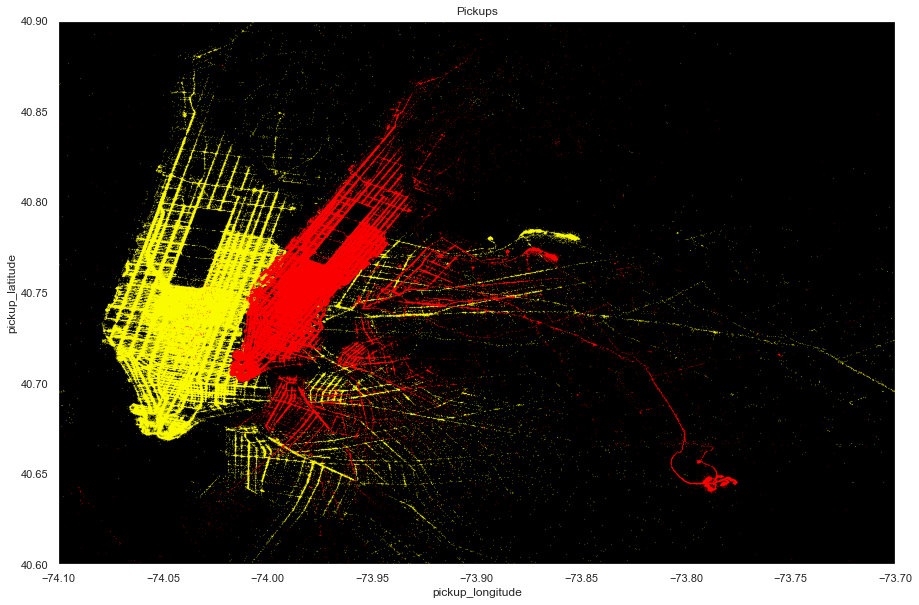

In [76]:
# К сожалению, повернуть карту адекватно не удалось, меняется масштаб точек. Максимально близко удалось только так построить.
# Красным выделены начальные точки, желтем - смещенные 

x1, y1, x2, y2 = -74.1, 40.6, -73.7, 40.9

f, ax1 = plt.subplots(1, 1, sharey=True,figsize=(15,10))

df.plot(kind='scatter', x='pickup_longitude_new', y='pickup_latitude_new', color='yellow', s=.02, alpha=.6, 
        subplots=True, ax=ax1, ylim = (y1, y2), xlim = (x1, x2), grid = False)

df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='red', s=.02, alpha=.6, 
        subplots=True, ax=ax1,  ylim = (y1, y2), xlim = (x1, x2), grid = False)

ax1.set_title("Pickups")
ax1.set_facecolor('black')

In [77]:
# Однако давайте посчитаем manhattan_distance напрямую без перестроения координат, воспользуемся чужими трудами
# https://www.kaggle.com/hpulkkinen/using-the-manhattan-distance-with-random-forest
# Утверждается, что дороги расположены под углом 29 градусов к оси Север-Юг.
# http://www.charlespetzold.com/etc/AvenuesOfManhattan/


def get_rotation(alpha):
    alpha_r = np.radians(alpha)
    return [[np.cos(alpha_r), -np.sin(alpha_r)],[np.sin(alpha_r), np.cos(alpha_r)]]

def manhattan_distance(a, b, rotation):
    h = a[0]-b[0]
    w = (a[1]-b[1]) * np.cos(np.radians(a[0]))   # Нормализация расстояния восток-запад к тому же масштабу, что и север-юг
    x = np.dot(rotation,[w, h])
    return abs(x[0])+abs(x[1])


In [78]:
df['manhattan_distance'] = manhattan_distance((df['pickup_latitude'].values, df['pickup_longitude'].values), 
                                              (df['dropoff_latitude'].values, df['dropoff_longitude'].values), 
                                              get_rotation(29))

In [79]:
df['log_manhattan_distance'] = np.log(manhattan_distance((df['pickup_latitude'].values, df['pickup_longitude'].values), 
                                                      (df['dropoff_latitude'].values, df['dropoff_longitude'].values), 
                                                        get_rotation(29)))

# Тут тоже надо обработать -inf, нулевое расстояние обозначим за 1 метр
df.log_manhattan_distance = df.log_manhattan_distance.apply(lambda x: np.log(0.001) if x == np.NINF else x)

In [80]:
df[['log_trip_duration', 'log_distance_haversine', 'log_manhattan_distance']].corr()

,log_trip_duration,log_distance_haversine,log_manhattan_distance
log_trip_duration,1.000000,0.722120,0.775508
log_distance_haversine,0.722120,1.000000,0.958941
log_manhattan_distance,0.775508,0.958941,1.000000


Корреляция больше между `log_manhattan_distance` и `log_trip_duration`, нежели `log_distance_haversine` и `log_trip_duration`. Хотя на начальном этапе казалось, что дороги за пределами города могут нивелировать эту разницу.

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [81]:
# Отмасштабируем log_manhattan_distance
scaler = StandardScaler()
log_manhattan_distance_scaled = scaler.fit_transform(df.log_manhattan_distance.values.reshape(-1, 1))
df['log_manhattan_distance_scaled'] = log_manhattan_distance_scaled

target_7 = df.log_trip_duration
features_7 = df.drop(columns = ['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                                'dropoff_latitude','start_trip', 'end_trip', 'log_trip_duration', 'route', 
                                'log_distance_haversine', 'dropoff_latitude_new', 'pickup_longitude_new', 
                                'pickup_latitude_new', 'dropoff_longitude_new', 'manhattan_distance', 
                                'log_manhattan_distance', 'log_distance_haversine', 'log_distance_haversine_scaled',
                                'distance_haversine'])

train_features_7, test_features_7, train_target_7, test_target_7 = train_test_split(features_7, 
                                                                                    target_7, 
                                                                                    train_size = 0.7, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 99)

rdg_7 = Ridge(alpha=1.0)
rdg_7.fit(train_features_7, train_target_7)
predict_7 = rdg_7.predict(test_features_7)

ridge_score_7 = rdg_7.score(test_features_7, test_target_7)
MSE_ridge_7 = mean_squared_error(test_target_7, predict_7)

print('R^2 = {}, MSE for Ridge = {}'.format(ridge_score_7, MSE_ridge_7))

R^2 = 0.6727503377954409, MSE for Ridge = 0.20772805795483482


**Вывод**: Функция потерь уменьшилась. Все-таки, изначальное предположение о том, что `manhattan_distance` будет лучше аппроксимировать фактическое расстояние и как следствие лучше предсказывать таргет оправдалось. Однако есть и вторая гипотеза, которая скорее всего ближе к правде. Суть в том, что наша функция потерь штрафует слабее за завышение предсказания нежели чем за его занижение относительно целевой переменной. А так как `manhattan_distance` в среднем больше `distance_haversine`, и скорее завышает значение, чем занижает, то функция потерь становится меньше.

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [85]:
df[['log_trip_duration', 'distance_haversine', 'log_distance_haversine', 'manhattan_distance', 'log_manhattan_distance']]

,log_trip_duration,distance_haversine,log_distance_haversine,manhattan_distance,log_manhattan_distance
0,6.122493,1.498521,0.404478,0.017133,-4.066748
1,6.498282,1.805507,0.590842,0.022528,-3.793009
2,7.661527,6.385098,1.853967,0.065441,-2.726601
3,6.063785,1.485498,0.395750,0.017357,-4.053740
4,6.077642,1.188588,0.172766,0.014569,-4.228865
...,...,...,...,...,...
1458639,6.658011,1.225080,0.203006,0.015177,-4.187960
1458640,6.486161,6.049836,1.800031,0.057755,-2.851538
1458641,6.639876,7.824606,2.057273,0.070588,-2.650895
1458642,5.924256,1.092564,0.088527,0.010805,-4.527764


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

Ссылки на источники вдохновения:
1. https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a
2. https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial
3. https://seaborn.pydata.org/generated/seaborn.heatmap.html
4. https://ru.stackoverflow.com/questions/1161594/Разбиение-области-на-ячейки-и-присвоение-меток-с-началом-и-концом
5. https://www.kaggle.com/poonaml/last-cab-to-new-york-animated-heatmap-trips-folium
6. https://www.kaggle.com/hpulkkinen/using-the-manhattan-distance-with-random-forest
7. http://www.charlespetzold.com/etc/AvenuesOfManhattan/